<a href="https://colab.research.google.com/github/dmburns1729/bootcamp_projects/blob/main/Belt_Exam_2_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Belt Exam Workbook


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import set_config
set_config(display='diagram')

from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, accuracy_score, classification_report)
                             
                             

In [ ]:
df = pd.read_csv('/content/Belt2_A_drugtype_v2_final.csv')
df.head()

,Age,Gender,BP,Cholesterol,Na_to_K,Drug
0,59.0,M,High,HIGH,13.935,drugQ
1,40.0,F,Normal,HIGH,10.103,drugZ
2,NaN,M,Normal,HIGH,9.084,drugZ
3,62.0,M,Normal,HIGH,16.594,drugZ
4,55.0,F,High,NORMAL,10.977,drugQ


# Clean Data


In [ ]:
# Make a copy of the data for cleaning
df_clean=df.copy()

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          237 non-null    float64
 1   Gender       296 non-null    object 
 2   BP           221 non-null    object 
 3   Cholesterol  296 non-null    object 
 4   Na_to_K      296 non-null    object 
 5   Drug         296 non-null    object 
dtypes: float64(1), object(5)
memory usage: 14.0+ KB


In [ ]:
df_clean.duplicated().sum()

15

In [ ]:
# Drop duplicated rows
df_clean.drop_duplicates()

,Age,Gender,BP,Cholesterol,Na_to_K,Drug
0,59.0,M,High,HIGH,13.935,drugQ
1,40.0,F,Normal,HIGH,10.103,drugZ
2,NaN,M,Normal,HIGH,9.084,drugZ
3,62.0,M,Normal,HIGH,16.594,drugZ
4,55.0,F,High,NORMAL,10.977,drugQ
...,...,...,...,...,...,...
290,51.0,M,High,HIGH,18.295,drugZ
292,NaN,F,Normal,HIGH,10.065,drugZ
293,49.0,M,Low,NORMAL,11.014,drugZ
294,29.0,F,High,NORMAL,9.475,drugQ


In [ ]:
df_clean.isna().sum()
# Shows missing values by column

Age            59
Gender          0
BP             75
Cholesterol     0
Na_to_K         0
Drug            0
dtype: int64

In [ ]:
# Check categorical columns for consistancy
# select only object columns
categoricals = df_clean.select_dtypes(include='object')

# check value counts for each object column
for col in categoricals.columns:
  print(col)
  print(categoricals[col].value_counts(), '\n')

Gender
M         149
F         137
male        4
female      2
Female      1
Male        1
femal       1
Femal       1
Name: Gender, dtype: int64 

BP
High      142
Normal     46
Low        33
Name: BP, dtype: int64 

Cholesterol
HIGH      156
NORMAL    117
norm        9
high        8
NORM        6
Name: Cholesterol, dtype: int64 

Na_to_K
12.307    7
13.967    7
13.091    7
12.766    7
11.198    7
         ..
10.091    1
16.275    1
8.107     1
10.443    1
12.879    1
Name: Na_to_K, Length: 183, dtype: int64 

Drug
drugQ    148
drugZ    148
Name: Drug, dtype: int64 



In [ ]:
# Rename inconsistant data
# Classify Male as 0 and female as 1
gender_col = {"M":"0", 'F':'1', 'male': '0','female': '1','Female': '1', 'Male': '0','femal': '1','Femal': '1'}
df_clean['Gender'] = df_clean['Gender'].replace(gender_col)
df_clean['Gender'].value_counts()

0    154
1    142
Name: Gender, dtype: int64

In [ ]:
df_clean.dtypes

Age            float64
Gender          object
BP              object
Cholesterol     object
Na_to_K         object
Drug            object
dtype: object

In [ ]:
df_clean['Gender']

0      0
1      1
2      0
3      0
4      1
      ..
291    1
292    1
293    0
294    1
295    1
Name: Gender, Length: 296, dtype: object

In [ ]:
# Value types are incorrect
# I couldn't find in my notes so I found this at https://sparkbyexamples.com/pandas/pandas-convert-string-to-float-type-dataframe/#:~:text=Use%20pandas%20DataFrame.,float64%20%2C%20numpy.

df_clean['Gender'] = df_clean['Gender'].astype('int64')
print(df_clean.dtypes)

Age            float64
Gender           int64
BP              object
Cholesterol     object
Na_to_K         object
Drug            object
dtype: object


In [ ]:
# Rename inconsistant value types

cholesterol_col = {"norm":"NORMAL", 'high':'HIGH', 'NORM': 'NORMAL'}
df_clean['Cholesterol'] = df_clean['Cholesterol'].replace(cholesterol_col)
df_clean['Cholesterol'].value_counts()

HIGH      164
NORMAL    132
Name: Cholesterol, dtype: int64

In [ ]:
# There is a typo in the Na_to_K column of 10.403_

Na_to_K_col = {"10.403_":"10.403"}
df_clean['Na_to_K'] = df_clean['Na_to_K'].replace(Na_to_K_col)
df_clean['Na_to_K'].value_counts()

12.307    7
13.967    7
13.091    7
12.766    7
11.198    7
         ..
10.091    1
16.275    1
8.107     1
10.443    1
12.879    1
Name: Na_to_K, Length: 183, dtype: int64

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          237 non-null    float64
 1   Gender       296 non-null    int64  
 2   BP           221 non-null    object 
 3   Cholesterol  296 non-null    object 
 4   Na_to_K      296 non-null    object 
 5   Drug         296 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 14.0+ KB


In [ ]:
# Reclassify 'Na_to_K' as float not object

df_clean['Na_to_K'] = df_clean['Na_to_K'].astype(float)
print(df_clean.dtypes)

Age            float64
Gender           int64
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object


In [ ]:
df_clean['Age'].value_counts()

36.0     9
43.0     7
55.0     7
61.0     7
42.0     7
32.0     7
28.0     6
39.0     6
37.0     6
69.0     6
31.0     6
60.0     6
67.0     6
23.0     6
53.0     6
70.0     6
26.0     6
29.0     5
59.0     5
57.0     5
44.0     5
49.0     5
19.0     5
48.0     5
47.0     4
56.0     4
24.0     4
50.0     4
45.0     4
65.0     4
58.0     4
40.0     4
20.0     4
66.0     3
22.0     3
62.0     3
35.0     3
18.0     3
72.0     3
73.0     3
54.0     3
74.0     3
71.0     2
51.0     2
64.0     2
41.0     2
30.0     2
21.0     2
52.0     2
34.0     2
38.0     2
15.0     2
16.0     2
46.0     2
63.0     1
33.0     1
25.0     1
570.0    1
68.0     1
Name: Age, dtype: int64

In [ ]:
# The person 570 years old is a typo.  Assume 57 - should ask to make sure not 70

df_clean['Age'] = df_clean['Age'].replace(570, 57)
df_clean['Age'].value_counts()

36.0    9
55.0    7
61.0    7
42.0    7
32.0    7
43.0    7
28.0    6
31.0    6
26.0    6
39.0    6
37.0    6
69.0    6
60.0    6
67.0    6
23.0    6
53.0    6
70.0    6
57.0    6
29.0    5
59.0    5
44.0    5
49.0    5
19.0    5
48.0    5
47.0    4
56.0    4
24.0    4
50.0    4
45.0    4
65.0    4
58.0    4
40.0    4
20.0    4
66.0    3
22.0    3
62.0    3
35.0    3
18.0    3
72.0    3
73.0    3
74.0    3
54.0    3
71.0    2
51.0    2
64.0    2
41.0    2
21.0    2
30.0    2
52.0    2
34.0    2
38.0    2
15.0    2
16.0    2
46.0    2
63.0    1
33.0    1
25.0    1
68.0    1
Name: Age, dtype: int64

In [ ]:
df_clean['Drug'].value_counts()

drugQ    148
drugZ    148
Name: Drug, dtype: int64

In [ ]:
# Looks balanced!  Won't need to rebalance

In [ ]:
# I am going to check the  categorical columns to see if I can clean anything else
# Check categorical columns for consistancy
# select only object columns
categoricals = df_clean.select_dtypes(include='object')

# check value counts for each object column
for col in categoricals.columns:
  print(col)
  print(categoricals[col].value_counts(), '\n')

BP
High      142
Normal     46
Low        33
Name: BP, dtype: int64 

Cholesterol
HIGH      164
NORMAL    132
Name: Cholesterol, dtype: int64 

Drug
drugQ    148
drugZ    148
Name: Drug, dtype: int64 



In [ ]:
# I am going to numeric encode the Cholesterol I can do this before the test/train split because the numeric encoding 
# does not depend on information from the test data, so does not cause data leakage. 

cholesterol_ordinal = {'NORMAL':'0', 'HIGH':'1'}
df_clean['Cholesterol'] = df_clean['Cholesterol'].replace(cholesterol_ordinal)
df_clean['Cholesterol'].value_counts()

1    164
0    132
Name: Cholesterol, dtype: int64

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          237 non-null    float64
 1   Gender       296 non-null    int64  
 2   BP           221 non-null    object 
 3   Cholesterol  296 non-null    object 
 4   Na_to_K      296 non-null    float64
 5   Drug         296 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ KB


In [ ]:
df_clean['Cholesterol'] = df_clean['Cholesterol'].astype('int64')
print(df_clean.dtypes)

Age            float64
Gender           int64
BP              object
Cholesterol      int64
Na_to_K        float64
Drug            object
dtype: object


In [ ]:
# I am going to set the BP unknowns to unknown so I don't introduce errors into the complete data sets
#I can do this before the test/train split because it 
# did not depend on information from the test data, so does not cause data leakage. 

df_clean['BP'].fillna(value = "Unknown", inplace = True)


In [ ]:
df_clean

,Age,Gender,BP,Cholesterol,Na_to_K,Drug
0,59.0,0,High,1,13.935,drugQ
1,40.0,1,Normal,1,10.103,drugZ
2,NaN,0,Normal,1,9.084,drugZ
3,62.0,0,Normal,1,16.594,drugZ
4,55.0,1,High,0,10.977,drugQ
...,...,...,...,...,...,...
291,44.0,1,High,1,12.854,drugQ
292,NaN,1,Normal,1,10.065,drugZ
293,49.0,0,Low,0,11.014,drugZ
294,29.0,1,High,0,9.475,drugQ


In [ ]:
df_clean.isna().sum()

Age            59
Gender          0
BP              0
Cholesterol     0
Na_to_K         0
Drug            0
dtype: int64

In [ ]:
# Only age has missing values!  

In [ ]:
# I am going to numeric encode the Cholesterol I can do this before the test/train split because the numeric encoding 
# does not depend on information from the test data, so does not cause data leakage. 

drug_ordinal = {'drugQ':'0', 'drugZ':'1'}
df_clean['Drug'] = df_clean['Drug'].replace(drug_ordinal)
df_clean['Drug'].value_counts()

0    148
1    148
Name: Drug, dtype: int64

In [ ]:
df_clean['Drug'] = df_clean['Drug'].astype('int64')
print(df_clean.dtypes)

Age            float64
Gender           int64
BP              object
Cholesterol      int64
Na_to_K        float64
Drug             int64
dtype: object


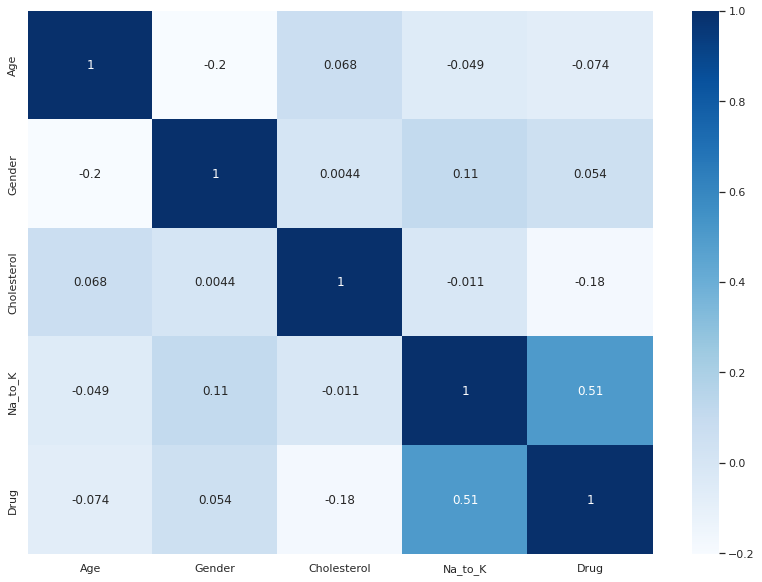

In [ ]:
corr = df_clean.corr()
plt.figure(figsize = (14,10));
sns.heatmap(corr, cmap = 'Blues', annot = True);

In [ ]:
# No data looks overly correlated with any other.  In fact, the correlations are pretty
# limited.  Hoping that the object data yields a good regression
# this data does not look like we are going to get a clean regression
# However, the target is not represented here.  I could encode the "Drug" values and 
# see if there is any correlation

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          237 non-null    float64
 1   Gender       296 non-null    int64  
 2   BP           296 non-null    object 
 3   Cholesterol  296 non-null    int64  
 4   Na_to_K      296 non-null    float64
 5   Drug         296 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 14.0+ KB


In [ ]:
df_clean.describe()

,Age,Gender,Cholesterol,Na_to_K
count,237.000000,296.000000,296.000000,296.000000
mean,45.358650,0.479730,0.554054,14.709355
std,16.133778,0.500435,0.497911,6.364668
min,15.000000,0.000000,0.000000,6.269000
25%,32.000000,0.000000,0.000000,10.445250
50%,45.000000,0.000000,1.000000,12.856000
75%,59.000000,1.000000,1.000000,16.732000
max,74.000000,1.000000,1.000000,38.247000


In [ ]:
# Everything looks good!  Now I will create some visualizations to understand the data better
# I am going to create a new copy of the data to prevent data leakage

# Visualize Data

In [ ]:
# I am going to impute some values so I will make a copy of the data for visualizations
# and do my regressions on the clean data

df_viz=df_clean.copy()

In [ ]:
df_viz.isna().sum()

Age            59
Gender          0
BP              0
Cholesterol     0
Na_to_K         0
Drug            0
dtype: int64

In [ ]:
# I am going to do a fillna to replace missing age data for visualization

mean_age = df_viz['Age'].mean()
df_viz['Age'].fillna(value = mean_age, inplace = True)


In [ ]:
df_viz.isna().sum()

Age            0
Gender         0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [ ]:
df_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          296 non-null    float64
 1   Gender       296 non-null    int64  
 2   BP           296 non-null    object 
 3   Cholesterol  296 non-null    int64  
 4   Na_to_K      296 non-null    float64
 5   Drug         296 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 14.0+ KB


In [ ]:
df_viz

,Age,Gender,BP,Cholesterol,Na_to_K,Drug
0,59.00000,0,High,1,13.935,drugQ
1,40.00000,1,Normal,1,10.103,drugZ
2,45.35865,0,Normal,1,9.084,drugZ
3,62.00000,0,Normal,1,16.594,drugZ
4,55.00000,1,High,0,10.977,drugQ
...,...,...,...,...,...,...
291,44.00000,1,High,1,12.854,drugQ
292,45.35865,1,Normal,1,10.065,drugZ
293,49.00000,0,Low,0,11.014,drugZ
294,29.00000,1,High,0,9.475,drugQ


In [ ]:
df_viz.describe()

,Age,Gender,Cholesterol,Na_to_K
count,296.00000,296.000000,296.000000,296.000000
mean,45.35865,0.479730,0.554054,14.709355
std,14.43049,0.500435,0.497911,6.364668
min,15.00000,0.000000,0.000000,6.269000
25%,36.00000,0.000000,0.000000,10.445250
50%,45.35865,0.000000,1.000000,12.856000
75%,56.00000,1.000000,1.000000,16.732000
max,74.00000,1.000000,1.000000,38.247000


In [ ]:
# Data all looks good.  I am going to create some visualizations

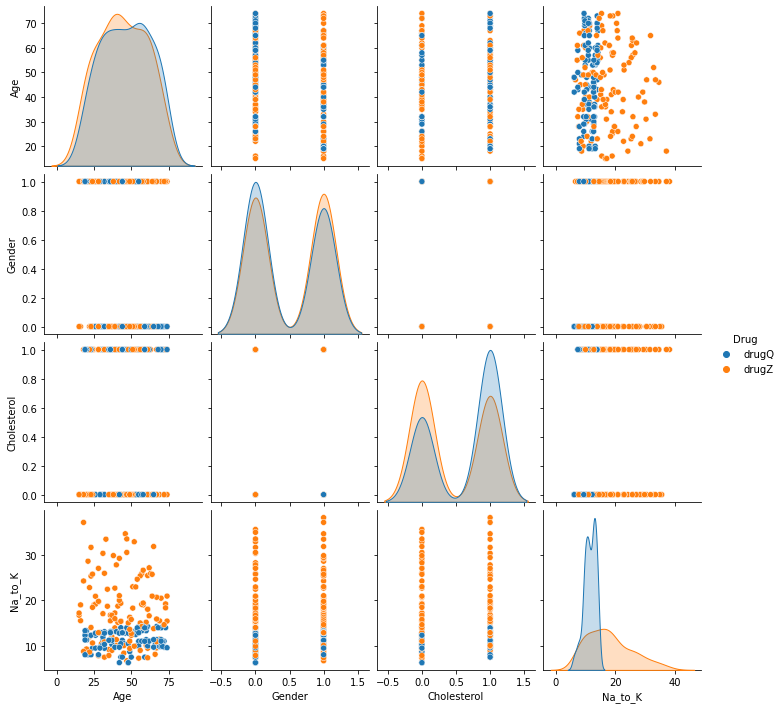

In [ ]:
import seaborn as sns
sns.pairplot(df_clean,hue = 'Drug');

# I got the idea for hue here: https://seaborn.pydata.org/generated/seaborn.pairplot.html 

In [ ]:
# This plot is hard to understand.  The two value data doesn't tell me much
# However, adding drug as hue gives us some info.  Drug Q seems most used
# for lower Na_to_K values.  It is also used more for high cholesterol.  It is
# also used slightly more for men, particularly older men.   Drug Z is used more for 
# older women.

# It would have been really nice if the cholesterol and blood pressure values were
# actually given not just a low, medium, and high!  

# This data is not separated out well.  Might be trouble for a regression


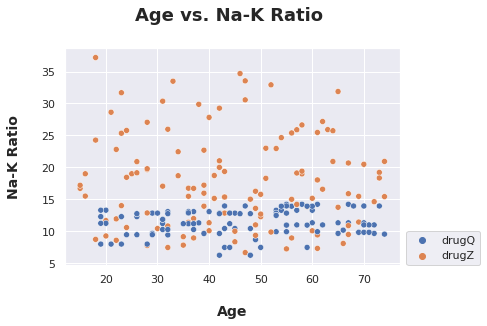

In [ ]:
fig = plt.figure(1)
sns.set(style="darkgrid")
ax = sns.scatterplot(data = df_clean, x = 'Age', y = 'Na_to_K', hue = 'Drug')
ax.legend(bbox_to_anchor=[1,1]);


# Title and labels
plt.title('Age vs. Na-K Ratio \n', fontsize = 18, weight='bold');
plt.xlabel('\nAge', fontsize = 14, weight='bold');
plt.ylabel('Na-K Ratio\n', fontsize = 14, weight='bold');
plt.legend(loc=(1.02,0));

# Drug Q seems most used for lower Na_to_K values.  


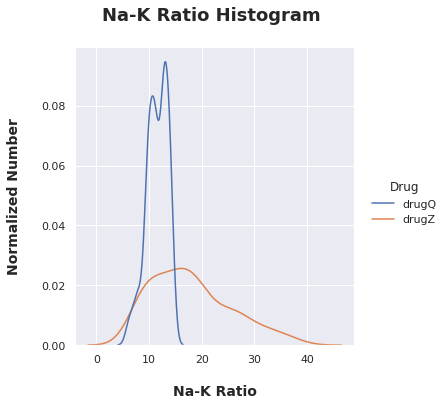

In [ ]:
sns.displot(df_clean, x="Na_to_K", hue = 'Drug',kind="kde");
# I liked the look of the one in the pairplot so I found it
# https://seaborn.pydata.org/tutorial/distributions.html

# Title and labels
plt.title('Na-K Ratio Histogram \n', fontsize = 18, weight='bold');
plt.xlabel('\nNa-K Ratio', fontsize = 14, weight='bold');
plt.ylabel('Normalized Number\n', fontsize = 14, weight='bold');





In [ ]:
# Drug Q seems exclusively used for Na_to_K values between 5 and 15.   This is a good visualization


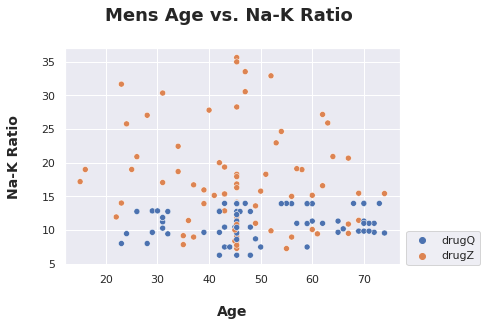

In [ ]:
fig = plt.figure(1)
sns.set(style="darkgrid")

men_only = df_viz.loc[df_viz['Gender'] == 0]

ax = sns.scatterplot(data = men_only, x = 'Age', y = 'Na_to_K', hue = 'Drug')
ax.legend(bbox_to_anchor=[1,1]);

# Title and labels
plt.title('Mens Age vs. Na-K Ratio \n', fontsize = 18, weight='bold');
plt.xlabel('\nAge', fontsize = 14, weight='bold');
plt.ylabel('Na-K Ratio\n', fontsize = 14, weight='bold');
plt.legend(loc=(1.02,0));



In [ ]:
# Drug Q is used more for older men but not as obviously as in the pairplot
# The verticle line in the middle is because we imputed the values at mean
# Not sure how we could change that or if it matters much

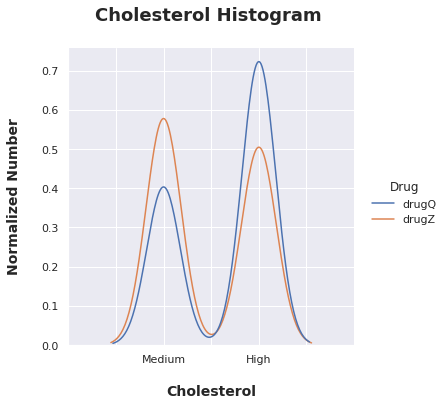

In [ ]:
g = sns.displot(df_clean, x="Cholesterol", hue = 'Drug',kind="kde");
# I liked the look of the one in the pairplot so I found it
# https://seaborn.pydata.org/tutorial/distributions.html

# Title and labels
plt.title('Cholesterol Histogram \n', fontsize = 18, weight='bold');
plt.xlabel('\nCholesterol', fontsize = 14, weight='bold');
plt.ylabel('Normalized Number\n', fontsize = 14, weight='bold');

#g = sns.lineplot(data=df)
g.set_xticklabels(['','','Medium','','High']);


# Here we see that drug Q is more for high cholesterol
# I didn't want to kill myself figuring out how to properly
# format the X-tixs.  I found this workaround on
# https://stackoverflow.com/questions/56605113/how-to-set-x-axis-ticklabels-in-a-seaborn-plot

In [ ]:
# Drug Q is used more for high cholesterol.  Not a lot of separation

# Regression

We are going to start with the cleaned data to prevent data leakage.

In [ ]:
df_ml = df_clean.copy()

In [ ]:
df_ml

,Age,Gender,BP,Cholesterol,Na_to_K,Drug
0,59.0,0,High,1,13.935,drugQ
1,40.0,1,Normal,1,10.103,drugZ
2,NaN,0,Normal,1,9.084,drugZ
3,62.0,0,Normal,1,16.594,drugZ
4,55.0,1,High,0,10.977,drugQ
...,...,...,...,...,...,...
291,44.0,1,High,1,12.854,drugQ
292,NaN,1,Normal,1,10.065,drugZ
293,49.0,0,Low,0,11.014,drugZ
294,29.0,1,High,0,9.475,drugQ


In [ ]:
# split X and y, we are predicting drug
X = df_ml.drop(columns=['Drug'])
y = df_ml['Drug']

# split training and test
# set random_state to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
                                                    

In [ ]:
#instantiate the StandardScaler, OneHotEncoder, and Imputers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')
# Setup the pipelines for the numeric and categorical data

# We don't strictly need the imputer for frequency since we dealt with the
# unknown BP values by filling in unknown when cleaning the data
# However, I ran this model about 65 times filling in the missing values
# at this step with 'unknown' before I just did it when cleaning the data
# when I realized that it wouldn't cause data leakage.  If you are going to 
# take a point away I could just go back to the old way and fill the unknowns for
# the df_viz and again here.   


num_pipeline = make_pipeline(mean_imputer, scaler)
nom_pipeline = make_pipeline(freq_imputer, ohe)

# Selectors
num_selector = make_column_selector(dtype_include='number')
nom_selector = make_column_selector(dtype_include='object')

# Setup the tuples to pair the processors with the make column selectors

numeric_tuple = (num_pipeline, num_selector)
nominal_tuple = (nom_pipeline, nom_selector)

# Instantiate the make column transformer
preprocessor = make_column_transformer(numeric_tuple,
                                       nominal_tuple,
                                       remainder='drop') 


# This next part is not strictly necessary and is more of a check that I got the 
# pipelines and preprocessor done correctly

# Fit the column transformer on the X_train
preprocessor.fit(X_train)

# Transform the X_train and the X_test

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_transformed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_transformed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_transformed.dtype)
print('All data in X_test_processed are', X_test_transformed.dtype)
print('\n')
print('shape of data is', X_train_transformed.shape)
print('\n')
X_train_transformed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (222, 8)




array([[-1.34083991,  1.04610689, -1.19981684, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.95592526, -1.19981684, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.04610689, -1.19981684, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.        , -0.95592526,  0.83346055, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , -0.95592526,  0.83346055, ...,  0.        ,
         0.        ,  0.        ],
       [-0.57674375,  1.04610689, -1.19981684, ...,  1.        ,
         0.        ,  0.        ]])

In [ ]:
# preprocessor looks good!


I need to decide what classification methods I am going to use.
I will try logistic regression, KNN, and RandomForestClassifier.  

Logistic regression is a little weird considering that although this was a binary classification,it was between two drugs and not yes or no or some such. 

In [ ]:
log_reg = LogisticRegression()

In [ ]:
log_reg_pipe = make_pipeline(preprocessor, log_reg)
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b5781e10>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b57818d0>)])),
                ('logisticregression', LogisticRegression())])

In [ ]:
## define the evaluate_classiffication function here.  I shameless ripped this idea 
# off from the code along notebook.  

def evaluate_classiffication(lgr_pipe, X_test, y_test, label="Test Data"):
  test_preds = lgr_pipe.predict(X_test)


   ## Print classification report for the test data 
  print('---'*20)
  print(f"CLASSIFICATION REPORT FOR: {label}")
  print('---'*20)
  # print the classiffication report from the test data
  print(classification_report(y_test, test_preds))

  fig, axes = plt.subplots(1,2, figsize=(15,5))

  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, 
               normalize='true', cmap='Greens',
               ax = axes[0]);

  RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax=axes[1])
  plt.show()

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.43      0.09      0.15        34
       drugZ       0.54      0.90      0.67        40

    accuracy                           0.53        74
   macro avg       0.48      0.49      0.41        74
weighted avg       0.49      0.53      0.43        74



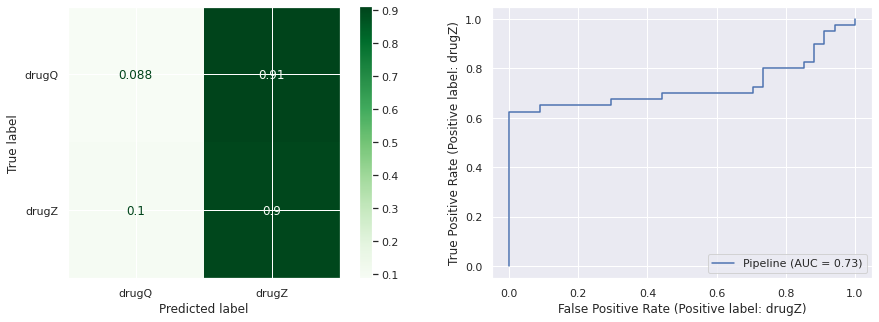

In [ ]:
evaluate_classiffication(log_reg_pipe, X_test, y_test, label="Test Data")

In [ ]:
# This regression is good at predicting drugZ bur pretty bad at drugQ

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.00      0.00      0.00        34
       drugZ       0.54      1.00      0.70        40

    accuracy                           0.54        74
   macro avg       0.27      0.50      0.35        74
weighted avg       0.29      0.54      0.38        74



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


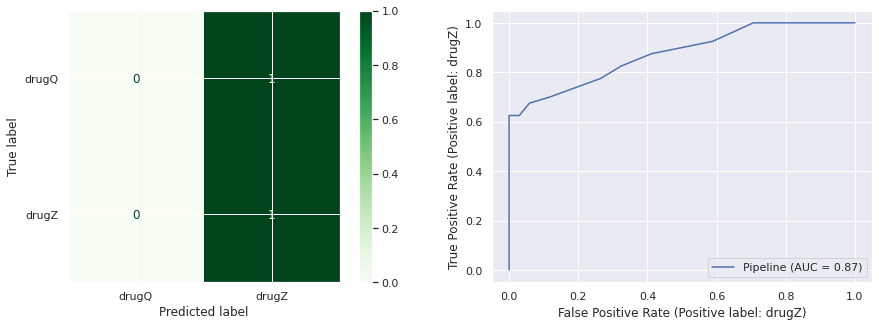

In [ ]:
# fit and evaluate a RandomForestClassifier
rf = RandomForestClassifier()
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)
evaluate_classiffication(rf_pipe, X_test, y_test)

In [ ]:
# Same problem with this one!  In fact, this one is worse and predicted all of them were drugZ!  
# We got a bunch of errors due to not predicting any drug Q

------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.70      0.91      0.79        34
       drugZ       0.90      0.68      0.77        40

    accuracy                           0.78        74
   macro avg       0.80      0.79      0.78        74
weighted avg       0.81      0.78      0.78        74



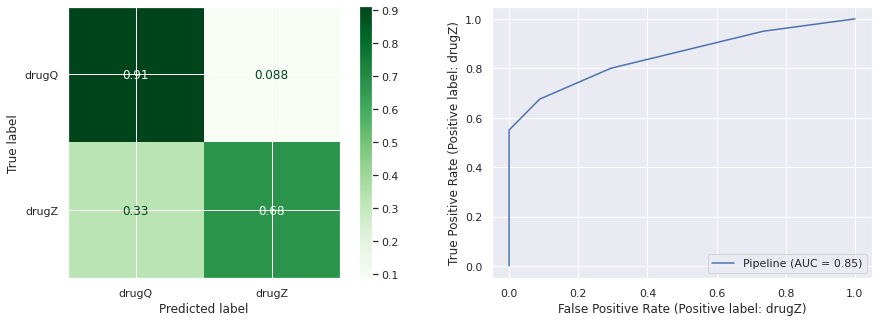

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# fit and evaluate a KNeighborsClassifier
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)
evaluate_classiffication(knn_pipe, X_test, y_test)

In [ ]:
# This model is better at predicting drugQ.  In fact, this is probably the best of the bunch so far.
# However, this one was worse at predictit drug Z

# Tune the regressions

In [ ]:
# I will start tuning the logistic regression

log_reg_pipe = make_pipeline(preprocessor, log_reg)
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b5781e10>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b57818d0>)])),
                ('logisticregression', LogisticRegression())])

{0.0001: 0.4594594594594595,
 0.001: 0.4594594594594595,
 0.01: 0.4594594594594595,
 0.1: 0.5675675675675675,
 1: 0.5405405405405406,
 10: 0.5,
 100: 0.6891891891891891,
 1000: 0.7027027027027027}

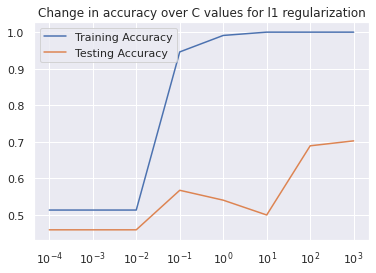

In [ ]:
# We will start tuning L1 first

# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
 
  # instantiate a model with each value of c and fit it on the data
  log_reg_tune1 = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg_tune1_pipe = make_pipeline(preprocessor, log_reg_tune1)
  log_reg_tune1_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_tune1_pipe.score(X_train, y_train))
  test_scores.append(log_reg_tune1_pipe.score(X_test, y_test))
 
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
 
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

{0.0001: 0.7432432432432432,
 0.001: 0.7432432432432432,
 0.01: 0.7432432432432432,
 0.1: 0.5945945945945946,
 1: 0.5135135135135135,
 10: 0.5135135135135135,
 100: 0.5,
 1000: 0.4864864864864865}

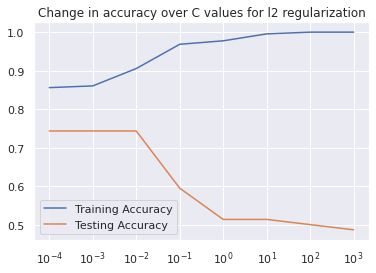

In [ ]:
# Tune L2

# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
  # instantiate a model with each value of c and fit it on the data
  log_reg_tune2 = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  log_reg_tune2_pipe = make_pipeline(preprocessor, log_reg_tune2)
  log_reg_tune2_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_tune2_pipe.score(X_train, y_train))
  test_scores.append(log_reg_tune2_pipe.score(X_test, y_test))
  
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l2 regularization')
ax.legend()
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

In [ ]:
#Looks like our best fit is with L2 at .0001.  Let check it out!

Original Log Reg Untuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.43      0.09      0.15        34
       drugZ       0.54      0.90      0.67        40

    accuracy                           0.53        74
   macro avg       0.48      0.49      0.41        74
weighted avg       0.49      0.53      0.43        74



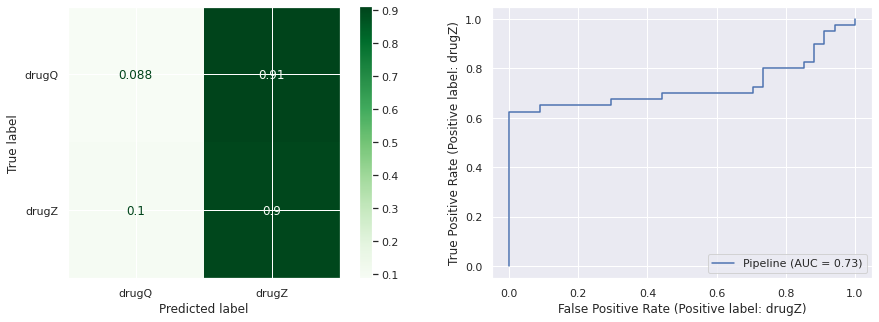

Best Log Reg Tuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.67      0.85      0.75        34
       drugZ       0.84      0.65      0.73        40

    accuracy                           0.74        74
   macro avg       0.76      0.75      0.74        74
weighted avg       0.76      0.74      0.74        74



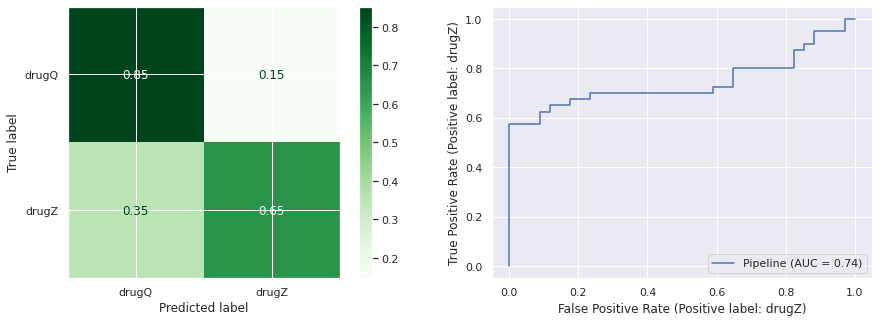

In [ ]:
log_reg_best = LogisticRegression(C=.001, max_iter=1000, solver='liblinear', penalty='l2')
log_reg_best_pipe = make_pipeline(preprocessor, log_reg_best)
log_reg_best_pipe.fit(X_train, y_train)
print("Original Log Reg Untuned")
evaluate_classiffication(log_reg_pipe, X_test, y_test, label="Test Data")
print("Best Log Reg Tuned")

evaluate_classiffication(log_reg_best_pipe, X_test, y_test, label="Test Data")

In [ ]:
# Better than the first one but still kinda crappy

In [ ]:
# How did it fit the train data?

Original Log Reg Untuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.97      1.00      0.99       114
       drugZ       1.00      0.97      0.99       108

    accuracy                           0.99       222
   macro avg       0.99      0.99      0.99       222
weighted avg       0.99      0.99      0.99       222



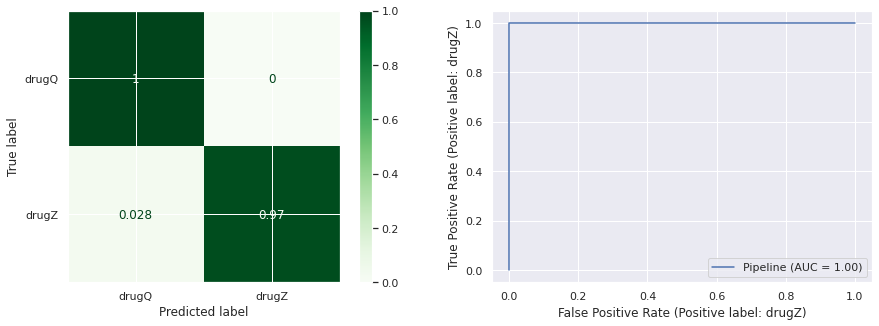

Best Log Reg Tuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.79      1.00      0.88       114
       drugZ       1.00      0.71      0.83       108

    accuracy                           0.86       222
   macro avg       0.89      0.86      0.86       222
weighted avg       0.89      0.86      0.86       222



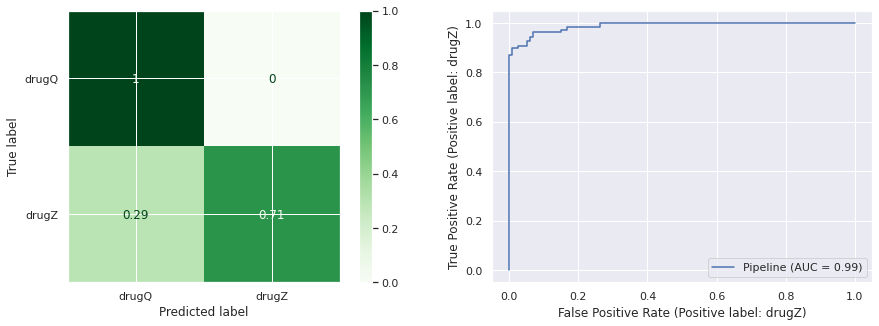

In [ ]:
print("Original Log Reg Untuned")
evaluate_classiffication(log_reg_pipe, X_train, y_train, label="Train Data")
print("Best Log Reg Tuned")
evaluate_classiffication(log_reg_best_pipe, X_train, y_train, label="Train Data")

In [ ]:
# This model overfit the train data in the first instance
# It overfit less after tuning but still pretty overfit

In [ ]:
# Tune the Random Forest Classifier

In [ ]:
rf_tune = RandomForestClassifier()
rf_tune_pipe = make_pipeline(preprocessor, rf_tune)

In [ ]:
rf_tune_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b5781e10>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                 

In [ ]:
#create and visualize our parameter grid
param_grid = {'randomforestclassifier__max_depth': [1,2,3,4,5,6,7,8,9,10],
              'randomforestclassifier__n_estimators': [1,2,3,4,5,6,7,8,9,10],
              'randomforestclassifier__min_samples_leaf': [1,2,3],
              'randomforestclassifier__min_samples_split': [1,2,3]
              }

# I ran this a few times and tinkered with the params

In [ ]:
model = rf_tune_pipe  
rf_tune_pipe_grid_search = GridSearchCV(model, param_grid)    


In [ ]:
rf_tune_pipe_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1500 fits failed out of a total of 4500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b5781e10>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='mos...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b57818d0>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 3],
                         'randomforestclassifier__min_samples_split': [1, 2, 3],
                         'randomforestclassifier__n_estimators': [1, 2, 3, 4, 5,
                                                                  6, 7, 8, 9,
                                                                  10]})

In [ ]:
#retrieve the best version of the model
best_model_rf = rf_tune_pipe_grid_search.best_estimator_

#refit the model on the whole training set
best_model_rf.fit(X_train, y_train)

#score the model on the test set
best_model_rf.score(X_test, y_test)


0.5540540540540541

In [ ]:
best_model_rf.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b5869910>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                 

Original Random Forest Untuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.00      0.00      0.00        34
       drugZ       0.54      1.00      0.70        40

    accuracy                           0.54        74
   macro avg       0.27      0.50      0.35        74
weighted avg       0.29      0.54      0.38        74



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


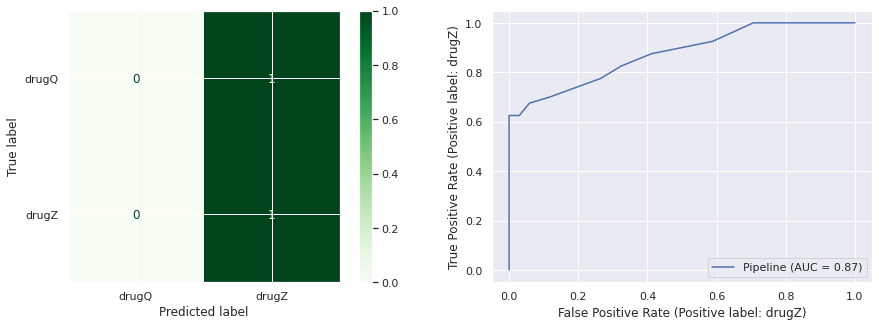

Best Random Forest Tuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       1.00      0.03      0.06        34
       drugZ       0.55      1.00      0.71        40

    accuracy                           0.55        74
   macro avg       0.77      0.51      0.38        74
weighted avg       0.76      0.55      0.41        74



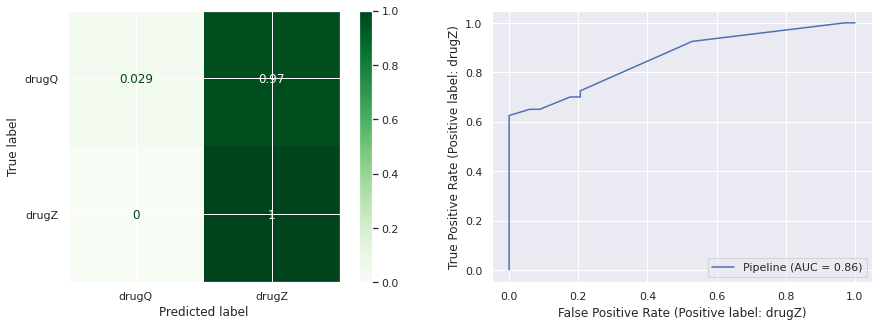

In [ ]:
print("Original Random Forest Untuned")
evaluate_classiffication(rf_pipe, X_test, y_test, label="Test Data")
print("Best Random Forest Tuned")
evaluate_classiffication(best_model_rf, X_test, y_test, label="Test Data")

In [ ]:
# Absolutely no change which is super weird.  Maybe it is better at the train data?

Original Random Forest Untuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       1.00      1.00      1.00       114
       drugZ       1.00      1.00      1.00       108

    accuracy                           1.00       222
   macro avg       1.00      1.00      1.00       222
weighted avg       1.00      1.00      1.00       222



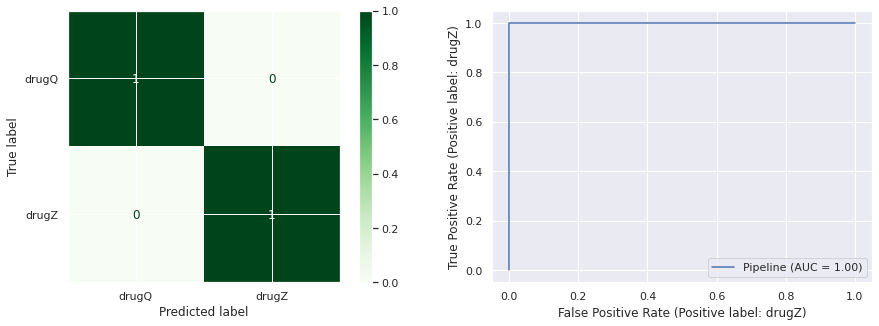

Best Random Forest Tuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       1.00      1.00      1.00       114
       drugZ       1.00      1.00      1.00       108

    accuracy                           1.00       222
   macro avg       1.00      1.00      1.00       222
weighted avg       1.00      1.00      1.00       222



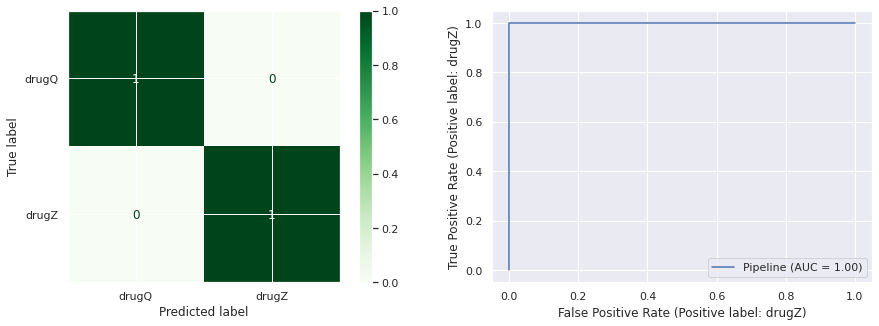

In [ ]:
print("Original Random Forest Untuned")
evaluate_classiffication(rf_pipe, X_train, y_train, label="Train Data")
print("Best Random Forest Tuned")
evaluate_classiffication(best_model_rf, X_train, y_train, label="Train Data")

In [ ]:
# Looks like both models absolutely killed it on the train data!  
# Way overfit on train but terrible at test

# Tuning is supposed to help with this!
# This model is just simply not going to work

In [ ]:
# Tune the KNN model

In [ ]:
num_neighbors = range(1,200)
scores = pd.DataFrame(index=num_neighbors, columns=['Test Score'])

for neighbors in num_neighbors:    
   model = KNeighborsClassifier(n_neighbors=neighbors)
   knn_pipe_tune = make_pipeline(preprocessor, model)
   knn_pipe_tune.fit(X_train, y_train)

   acc_score_train = knn_pipe.score(X_train, y_train)
   acc_score_test = knn_pipe.score(X_test, y_test)


   scores.loc[neighbors, 'Train Score'] = acc_score_train
   scores.loc[neighbors, 'Test Score'] = acc_score_test
   scores.head()

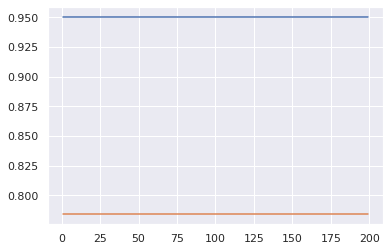

In [ ]:
import matplotlib.pyplot as plt


plt.plot(scores['Train Score']);
plt.plot(scores['Test Score']);

In [ ]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
1,0.783784,0.95045
126,0.783784,0.95045
128,0.783784,0.95045
129,0.783784,0.95045
130,0.783784,0.95045


In [ ]:
model = KNeighborsClassifier(n_neighbors=1)
knn_pipe_tune = make_pipeline(preprocessor, model)
knn_pipe_tune.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b5781e10>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f36b57818d0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

Original KNN Untuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.70      0.91      0.79        34
       drugZ       0.90      0.68      0.77        40

    accuracy                           0.78        74
   macro avg       0.80      0.79      0.78        74
weighted avg       0.81      0.78      0.78        74



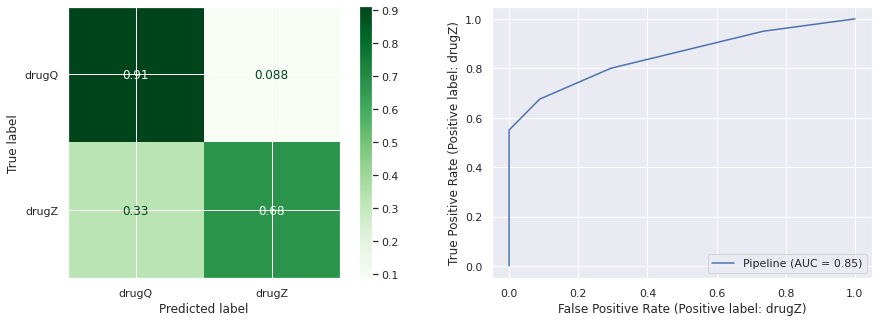

Best KNN Tuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.73      0.71      0.72        34
       drugZ       0.76      0.78      0.77        40

    accuracy                           0.74        74
   macro avg       0.74      0.74      0.74        74
weighted avg       0.74      0.74      0.74        74



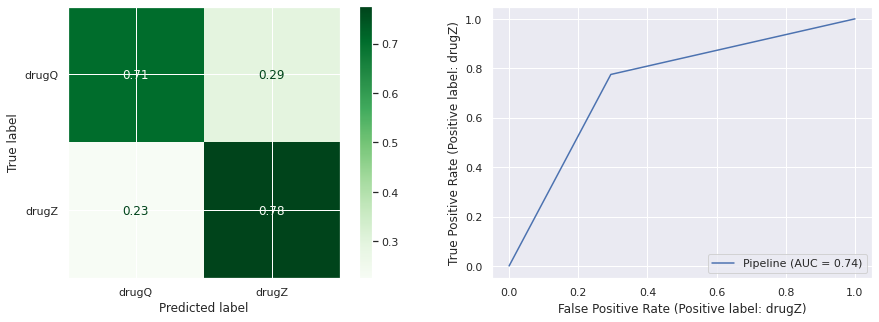

In [ ]:
print("Original KNN Untuned")
evaluate_classiffication(knn_pipe, X_test, y_test, label="Test Data")
print("Best KNN Tuned")
evaluate_classiffication(knn_pipe_tune, X_test, y_test, label="Test Data")

Original KNN Untuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.91      1.00      0.95       114
       drugZ       1.00      0.90      0.95       108

    accuracy                           0.95       222
   macro avg       0.96      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222



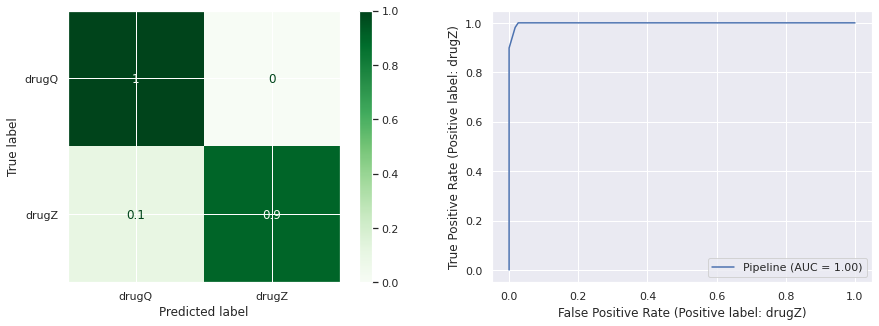

Best KNN Tuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       1.00      1.00      1.00       114
       drugZ       1.00      1.00      1.00       108

    accuracy                           1.00       222
   macro avg       1.00      1.00      1.00       222
weighted avg       1.00      1.00      1.00       222



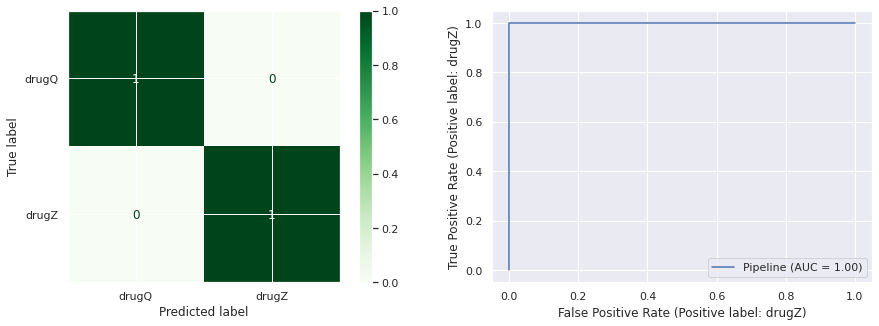

In [ ]:
print("Original KNN Untuned")
evaluate_classiffication(knn_pipe, X_train, y_train, label="Train Data")
print("Best KNN Tuned")
evaluate_classiffication(knn_pipe_tune, X_train, y_train, label="Train Data")

In [ ]:
# All of these models overfit on the train data.  
# The model with the best result was the tuned KNN model 
# judging by the accuracy and predictive results.  

# The model with the second best results was the 
# logistic regression model 

# Both models have an AUC of .74

# Depending on which error type is more important
# you may want to choose either one

Best Log Reg Tuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.67      0.85      0.75        34
       drugZ       0.84      0.65      0.73        40

    accuracy                           0.74        74
   macro avg       0.76      0.75      0.74        74
weighted avg       0.76      0.74      0.74        74



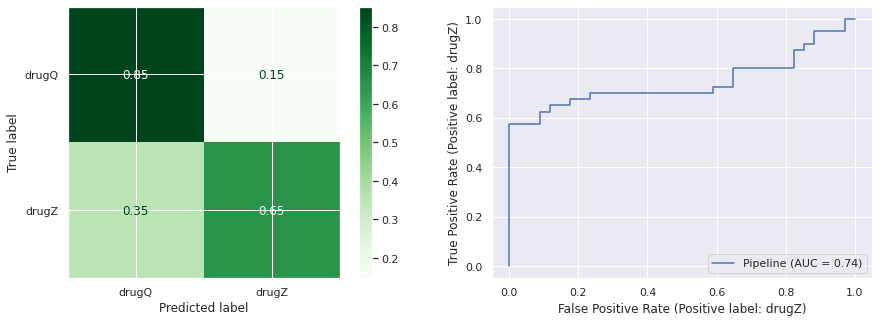

Best KNN Tuned
------------------------------------------------------------
CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

       drugQ       0.73      0.71      0.72        34
       drugZ       0.76      0.78      0.77        40

    accuracy                           0.74        74
   macro avg       0.74      0.74      0.74        74
weighted avg       0.74      0.74      0.74        74



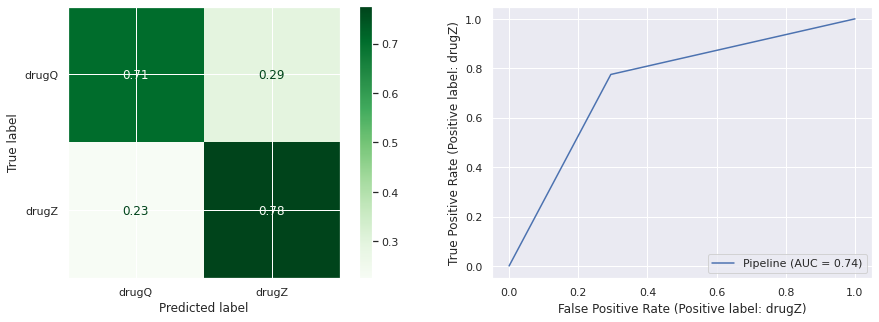

In [ ]:
print("Best Log Reg Tuned")
evaluate_classiffication(log_reg_best_pipe, X_test, y_test, label="Test Data")
print("Best KNN Tuned")
evaluate_classiffication(knn_pipe_tune, X_test, y_test, label="Test Data")